In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms
from torch.distributions.normal import Normal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob 
from PIL import Image

In [2]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.measure import shannon_entropy

In [3]:
torch.__version__

NameError: name 'torch' is not defined

In [5]:
#获取测试数据路径
train_irimgs_path = glob.glob('data/MSRS-main/train/ir/*.png')
train_viimgs_path = glob.glob('data/MSRS-main/train/vi/*.png')
# train_irimgs_path = glob.glob('data/TNO/ir/*.png')
# train_viimgs_path = glob.glob('data/TNO/vi/*.png')
#获取测试数据路径
test_irimgs_path = glob.glob('data/MSRS-main/test/ir/*.png')
test_viimgs_path = glob.glob('data/MSRS-main/test/vi/*.png')

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    transforms.Normalize(mean=0.5,std=0.5)
])

In [8]:
vi_img = Image.open(train_viimgs_path[1])
ir_img = Image.open(train_irimgs_path[1])
ir_img = ir_img.convert('RGB')

In [9]:
np.array(ir_img).shape,np.array(vi_img).shape

((576, 768, 3), (576, 768, 3))

In [10]:
class FusionDataset(data.Dataset):
    def __init__(self,ir_path,vi_path):
        self.ir_path = train_irimgs_path
        self.vi_path = train_viimgs_path
    def __getitem__(self,idx):
        # 得到路径
        vi_path = self.vi_path[idx]
        ir_path = self.ir_path[idx]
        # 根据路径得到图片
        vi_img = Image.open(vi_path)
        ir_img = Image.open(ir_path) #ir红外读取为灰度秃了
        vi_img = transform(vi_img)
        ir_img = ir_img.convert('RGB')# 将灰度图转换为三通道再变化
        ir_img = transform(ir_img)
        return vi_img,ir_img
    def __len__(self):
        return len(self.ir_path)
        

In [11]:
train_ds = FusionDataset(train_irimgs_path,train_viimgs_path)
test_ds = FusionDataset(test_irimgs_path,test_viimgs_path)

In [12]:
BATCHSIZE = 128
train_dl = data.DataLoader(dataset=train_ds,
                          batch_size=BATCHSIZE,
                          shuffle=True)

test_dl = data.DataLoader(dataset=test_ds,
                          batch_size=BATCHSIZE,
                          shuffle=False)

In [13]:
ir_batch,vi_batch = next(iter(train_dl))

In [14]:
ir_batch.shape,vi_batch.shape

(torch.Size([42, 3, 256, 256]), torch.Size([42, 3, 256, 256]))

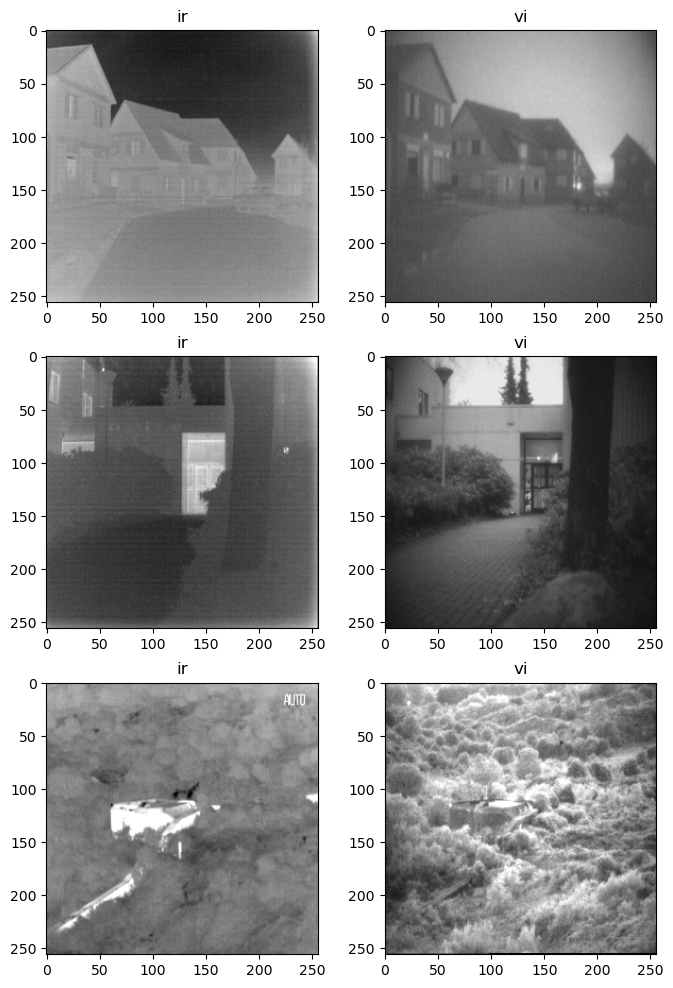

In [15]:
plt.figure(figsize = (8,12))
for i,(vi,ir) in enumerate(zip(ir_batch[:3],vi_batch[:3])):
    ir = (ir.permute(1,2,0).numpy()+1)/2
    vi = (vi.permute(1,2,0).numpy()+1)/2
    plt.subplot(3,2,2*i+1)
    plt.title('ir')
    plt.imshow(ir)
    plt.subplot(3,2,2*i+2)
    plt.title('vi')
    plt.imshow(vi)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [17]:
# define a class for sampling
# this class will be used in the encoder for sampling in the latent space
class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        # get the shape of the tensor for the mean and log variance
        batch, dim = z_mean.shape
        # generate a normal random tensor (epsilon) with the same shape as z_mean
        # this tensor will be used for reparameterization trick
        epsilon = Normal(0, 1).sample((batch, dim)).to(z_mean.device)
        # apply the reparameterization trick to generate the samples in the
        # latent space
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

In [18]:
# define the encoder
class Encoder(nn.Module):
    def __init__(self, image_size, embedding_dim):
        super(Encoder, self).__init__()
        # define the convolutional layers for downsampling and feature
        # extraction
        self.conv1 = nn.Conv2d(6, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        # define a flatten layer to flatten the tensor before feeding it into
        # the fully connected layer
        self.flatten = nn.Flatten()
        # define fully connected layers to transform the tensor into the desired
        # embedding dimensions
        self.fc_mean = nn.Linear(128 * (image_size // 8) * (image_size // 8), embedding_dim)
        self.fc_log_var = nn.Linear(128 * (image_size // 8) * (image_size // 8), embedding_dim)
        # initialize the sampling layer
        self.sampling = Sampling()
    def forward(self, x):
        # apply convolutional layers with relu activation function
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # flatten the tensor
        x = self.flatten(x)
        # get the mean and log variance of the latent space distribution
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        # sample a latent vector using the reparameterization trick
        z = self.sampling(z_mean, z_log_var)
        return z_mean, z_log_var, z

In [19]:
# define the decoder
class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening):
        super(Decoder, self).__init__()
        # define a fully connected layer to transform the latent vector back to
        # the shape before flattening
        self.fc = nn.Linear(
            embedding_dim,
            shape_before_flattening[0]
            * shape_before_flattening[1]
            * shape_before_flattening[2],
        )
        # define a reshape function to reshape the tensor back to its original
        # shape
        self.reshape = lambda x: x.view(-1, *shape_before_flattening)
        # define the transposed convolutional layers for the decoder to upsample
        # and generate the reconstructed image
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1)
    def forward(self, x):
        # pass the latent vector through the fully connected layer
        x = self.fc(x)
        # reshape the tensor
        x = self.reshape(x)
        # apply transposed convolutional layers with relu activation function
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        # apply the final transposed convolutional layer with a sigmoid
        # activation to generate the final output
        x = torch.tanh(self.deconv3(x))
        return x

In [20]:
# define the vae class
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        # initialize the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder
    def forward(self, x1,x2):
        # pass the input through the encoder to get the latent vector
        x = torch.cat([x1,x2],axis = 1)
        z_mean, z_log_var, z = self.encoder(x)
        # pass the latent vector through the decoder to get the reconstructed
        # image
        reconstruction = self.decoder(z)
        # return the mean, log variance and the reconstructed image
        return z_mean, z_log_var, reconstruction

In [21]:
def vae_gaussian_kl_loss(mu, logvar):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return KLD.mean()
def reconstruction_loss(x_reconstructed, x):
    bce_loss = nn.BCELoss()
    return bce_loss(x_reconstructed, x)
def vae_loss(y_pred, y_true):
    mu, logvar, recon_x = y_pred
    # mu = mu.detch()
    recon_loss = reconstruction_loss(recon_x, y_true)
    kld_loss = vae_gaussian_kl_loss(mu, logvar)
    return 500 * recon_loss + kld_loss

In [34]:
# instantiate the encoder and decoder models
encoder = Encoder(256, 128).to(device)
decoder = Decoder(128, (128, 256 // 8, 256 // 8)).to(device)

In [35]:
gen = VAE(encoder, decoder).to(device)
dis = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [36]:
fc = nn.Sequential(
    nn.Linear(in_features=256, out_features=2, bias=True),
    nn.Sigmoid()
)

In [37]:
dis.fc = fc

In [38]:
dis = dis.to(device)

In [39]:
if torch.cuda.device_count() > 1:
    gen = nn.DataParallel(gen)  # 就在这里wrap一下，模型就会使用所有的GPU
    dis = nn.DataParallel(dis)  # 就在这里wrap一下，模型就会使用所有的GPU

In [40]:
d_optimizer = torch.optim.Adam(dis.parameters(),lr = 1e-4,betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(gen.parameters(),lr = 1e-4,betas=(0.5,0.999))

In [41]:
# 定义损失函数
loss_fn = torch.nn.BCELoss()
# L1

In [42]:
LAMDA = 9

In [43]:
def calculate_metrics(vi, ir,fusion):
    # Information Entropy (EN)
    def calculate_entropy(fusion):
        img_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        entropy_value = shannon_entropy(img_gray)
        return entropy_value

    # Standard Deviation (SD)
    def calculate_sd(fusion):
        img_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        sd_value = np.std(img_gray)
        return sd_value

    # Structural Similarity Index (SSIM)
    def calculate_ssim(vi, ir ,fusion):
        img1_gray = cv2.cvtColor(vi, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(ir, cv2.COLOR_BGR2GRAY)
        fusion_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        ssim_index_A, _ = ssim(img1_gray, fusion_gray, full=True)
        ssim_index_B, _ = ssim(img2_gray, fusion_gray, full=True)
        return (ssim_index_A + ssim_index_B)/2 

    # Correlation Coefficient (CC)
    def calculate_cc(vi, ir ,fusion):
        img1_flat = vi.flatten()
        img2_flat = ir.flatten()
        fusion_flat = fusion.flatten()
        correlation_coefficient_A = np.corrcoef(img1_flat, fusion_flat)[0, 1]
        correlation_coefficient_B = np.corrcoef(img2_flat, fusion_flat)[0, 1]
        return (correlation_coefficient_A + correlation_coefficient_B)/2

    # Spatial Frequency (SF)
    def calculate_sf(fusion):
        img_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        f = np.fft.fft2(img_gray)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        spatial_frequency = np.sum(magnitude_spectrum) / img_gray.size
        return spatial_frequency

    # Variable Luminance Fusion Index (VLF)
    def calculate_vlf(vi, ir ,fusion):
        img1_gray = cv2.cvtColor(vi, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(ir, cv2.COLOR_BGR2GRAY)
        fusion_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        
        vlf_value_A = np.sum(np.abs(img1_gray - fusion_gray)) / img1_gray.size
        vlf_value_B = np.sum(np.abs(img2_gray - fusion_gray)) / img2_gray.size
        return (vlf_value_A + vlf_value_B)/2

    # Calculate metrics
    entropy_value = calculate_entropy(fusion)
    sd_value = calculate_sd(fusion)
    ssim_value = calculate_ssim(vi, ir,fusion)
    cc_value = calculate_cc(vi, ir,fusion)
    sf_value = calculate_sf(fusion)
    vlf_value = calculate_vlf(vi, ir,fusion)
    return {
        'Entropy': entropy_value,
        'Standard Deviation': sd_value,
        'SSIM': ssim_value,
        'Correlation Coefficient': cc_value,
        'Spatial Frequency': sf_value,
        'Variable Luminance Fusion Index': vlf_value
    }

In [44]:
def genarate_images(model,ir,vi):
    prediction = model(vi,ir)
    prediction = prediction[2].permute(0,2,3,1).detach().cpu().numpy()
    ir = ir.permute(0,2,3,1).cpu().numpy()
    vi = vi.permute(0,2,3,1).cpu().numpy()
    plt.figure(figsize=(10,10))
    display_list = [ir[0],vi[0],prediction[0]]
    fusion_result = calculate_metrics(vi[0], ir[0],prediction[0])
    print(fusion_result)
    title = ['ir','vi','fusion']
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
    plt.show()
    return fusion_result

In [45]:
D_loss = []
G_loss = []
res = []
for epoch in range(5000):
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(train_dl)
    for step,(vi,ir) in enumerate(train_dl):
        ir = ir.to(device)
        vi = vi.to(device)
        d_optimizer.zero_grad()
        #输入真实图片，判别器判定为真
        disc_real_output = dis(vi) #输入真实的成对图片
        d_real_loss = loss_fn(disc_real_output,torch.ones_like(disc_real_output,device = device))
        d_real_loss.backward() # 反向传播
        #生成图片
        gen_output = gen(vi,ir) #生成图片
        vi_disc_gen_output = dis(gen_output[2].detach()) #输入生成图像，判断可见光
        vi_d_fake_loss = loss_fn(vi_disc_gen_output,torch.zeros_like(vi_disc_gen_output,device = device))
        vi_d_fake_loss.backward() #生成图片进入判别器进行反向传播
        # 判定器的loss由两部分组成
        disc_loss = d_real_loss +(vi_d_fake_loss)
        #更新判别器参数
        d_optimizer.step()
        g_optimizer.zero_grad()
        # 将生成的图片放入判别器，要求骗过判别器
        vi_disc_gen_out = dis(gen_output[2].detach())
        # 得到生成器的损失
        vi_gen_loss_crossentropyloss = loss_fn(vi_disc_gen_out,torch.ones_like(vi_disc_gen_out,device = device))
        vi_gen_l1_loss = torch.mean(torch.abs(gen_output[2] - vi*0.5 - ir*0.5))
        gen_loss = vi_gen_loss_crossentropyloss+ LAMDA*(vi_gen_l1_loss)
        gen_loss.backward()
        #更新生成器梯度
        g_optimizer.step()
        with torch.no_grad():
            D_epoch_loss += disc_loss.item()
            G_epoch_loss += gen_loss.item()
    with torch.no_grad():
        D_epoch_loss /=count
        G_epoch_loss /=count
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        # 训练完一个epoch就打印输出
        print("Epoch:",epoch,end=' ')
        if epoch%49==0:
            ress = genarate_images(gen,ir,vi)
            res.append(ress)
        print(f'D_epoch_loss:{D_epoch_loss},G_epoch_loss{G_epoch_loss}')

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/root/anaconda3/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/root/anaconda3/lib/python3.10/site-packages/torchvision/models/resnet.py", line 285, in forward
    return self._forward_impl(x)
  File "/root/anaconda3/lib/python3.10/site-packages/torchvision/models/resnet.py", line 280, in _forward_impl
    x = self.fc(x)
  File "/root/anaconda3/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/root/anaconda3/lib/python3.10/site-packages/torch/nn/modules/container.py", line 204, in forward
    input = module(input)
  File "/root/anaconda3/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "/root/anaconda3/lib/python3.10/site-packages/torch/nn/modules/linear.py", line 114, in forward
    return F.linear(input, self.weight, self.bias)
RuntimeError: mat1 and mat2 shapes cannot be multiplied (21x512 and 256x2)


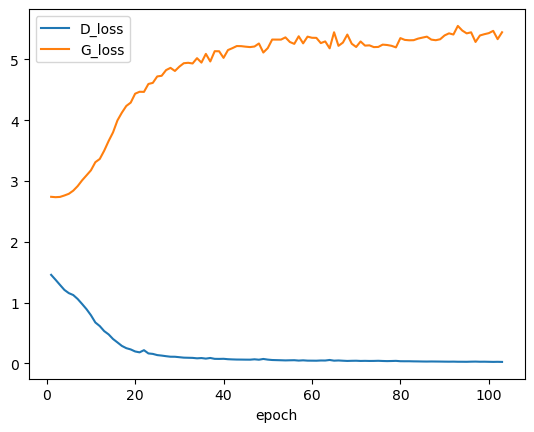

In [77]:
plt.plot(range(1, len(res)+1), D_loss[:len(res)], label='D_loss')
plt.plot(range(1, len(res)+1), G_loss[:len(res)], label='G_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [66]:
len(D_loss)

5000

In [67]:
import pandas as pd

In [68]:
data = pd.DataFrame()

In [70]:
data['res'] = res
data['Gloss'] = G_loss[len(res)]
data['Dloss'] = D_loss[len(res)]

In [74]:
data.to_excel('excel/00.xlsx')

In [75]:
# 模型参数保存
torch.save(gen.state_dict(), 'w/model_00.pth')

In [ ]:
# 模型参数加载
model = ModelClass(...)
model.load_state_dict(torch.load('model_param00.pth'))